In [8]:
import torch
from torch.utils.data import Dataset, ConcatDataset
from torchvision import transforms

import random
import os
import numpy as np
from PIL import Image
import natsort
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
from torchvision import models


import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(f'Using device: {device}')

Using device: cuda:0


In [4]:
class MakeDataset(Dataset):
    def __init__(self,image_list,label_list,transform = None):
        self.image_list = image_list
        self.label_list = label_list
        self.transform = transform
        
    def __len__(self):
        return len(self.image_list)
    
    def __getitem__(self,idx):
        image = self.image_list[idx]
        label = self.label_list[idx]
        
        if self.transform is not None:
#             image = (image * 255).astype(np.uint8)
            image = self.transform(image)
        
        return image, label   ##x,y를 tuple형태로 내보냄 


In [5]:
X_train = np.load('/mnt/disk1/jongmok/chaeyun/서울아산병원 /full_stage/testtest/xtrain.npy') 
X_valid = np.load('/mnt/disk1/jongmok/chaeyun/서울아산병원 /full_stage/testtest/xvalid.npy') 
X_test = np.load('/mnt/disk1/jongmok/chaeyun/서울아산병원 /full_stage/testtest/xtest.npy') 

y_train = np.load('/mnt/disk1/jongmok/chaeyun/서울아산병원 /full_stage/testtest/ytrain.npy') 
y_valid = np.load('/mnt/disk1/jongmok/chaeyun/서울아산병원 /full_stage/testtest/yvalid.npy') 
y_test = np.load('/mnt/disk1/jongmok/chaeyun/서울아산병원 /full_stage/testtest/ytest.npy') 

In [ ]:

learning_rate = 1e-4
num_epochs = 1000

In [6]:
train_dataset = MakeDataset(X_train, y_train, transform = None)
val_dataset = MakeDataset(X_valid, y_valid, transform = None)
test_dataset = MakeDataset(X_test, y_test, transform = None)

In [7]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size= 32,shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size= 32,shuffle = True)

In [19]:
class DeeperCNN3D(nn.Module):
    def __init__(self, n_filter1=32, n_filter2=64, n_filter3=128, n_filter4=128, dense_units=128):
        super(DeeperCNN3D, self).__init__()
        n_channels = 4  # 입력 채널 수 (예: 오존, 강수량, 기온, 산소포화량)
        time_size = 3
        grid_size = 32

        # 첫 번째 블록
        self.conv1 = nn.Conv3d(in_channels=n_channels, out_channels=n_filter1, kernel_size=(1,2,2), padding=(0, 1, 1))
        self.pool1 = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))

        # 두 번째 블록
        self.conv2 = nn.Conv3d(in_channels=n_filter1, out_channels=n_filter2, kernel_size=(1,2,2), padding=(0, 1, 1))
        self.pool2 = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))

        # 세 번째 블록
        self.conv3 = nn.Conv3d(in_channels=n_filter2, out_channels=n_filter3, kernel_size=(1,2,2), padding=(0, 1, 1))
        self.pool3 = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))

        # 네 번째 블록 (n_filter4 = 128로 설정)
        self.conv4 = nn.Conv3d(in_channels=n_filter3, out_channels=n_filter4, kernel_size=(1,2,2), padding=(0, 1, 1))
        self.pool4 = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))


        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(1536, dense_units)
        self.fc2 = nn.Linear(dense_units, dense_units // 2)
        self.fc3 = nn.Linear(dense_units // 2, 32 * 32)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool1(x)
        x = torch.relu(self.conv2(x))
        x = self.pool2(x)
        x = torch.relu(self.conv3(x))
        x = self.pool3(x)
        x = torch.relu(self.conv4(x))
        x = self.pool4(x)
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
model = DeeperCNN3D().to(device)

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, ConcatDataset
from torchvision import transforms

In [21]:
learning_rate = 1e-4
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()
epoch = 0
num_epochs = 1000
max_loss = np.inf

In [23]:

while epoch < num_epochs:

    model.train()
    total_train_samples = 0
    losses = 0
   

    for images,labels in train_loader:
        images = images.float()
        images = images.to(device)
        images = images.permute(0,4,1,2,3).to(device)
        labels = labels.float()
        labels = labels.to(device)

        optimizer.zero_grad()
        # Forward pass

        outputs = model(images)
        loss = criterion(outputs, labels)
        
        total_train_samples += labels.size(0) #현재 배치의 샘플 수 
        losses += loss

        # Backpropagation
        loss.backward()
        optimizer.step()
        
    train_loss = losses/total_train_samples


    if train_loss  < max_loss:
            max_loss = train_loss
            path = './testtest.pt'
            torch.save(model.state_dict(), path)
            print('Best model saved.')

    print('Epoch [{}/{}],Train_loss = {} '.format(epoch+1, num_epochs,train_loss))
    epoch = epoch + 1

Best model saved.
Epoch [1/1000],Train_loss = 6.808457692386582e-05 
Epoch [2/1000],Train_loss = 6.897260755067691e-05 
Best model saved.
Epoch [3/1000],Train_loss = 6.56826960039325e-05 
Best model saved.
Epoch [4/1000],Train_loss = 6.226429104572162e-05 
Best model saved.
Epoch [5/1000],Train_loss = 6.121600745245814e-05 
Best model saved.
Epoch [6/1000],Train_loss = 6.082521576900035e-05 
Best model saved.
Epoch [7/1000],Train_loss = 5.843285543960519e-05 
Best model saved.
Epoch [8/1000],Train_loss = 5.743144720327109e-05 
Best model saved.
Epoch [9/1000],Train_loss = 5.707900345441885e-05 
Best model saved.
Epoch [10/1000],Train_loss = 5.2726940339198336e-05 
Epoch [11/1000],Train_loss = 5.33920647285413e-05 
Best model saved.
Epoch [12/1000],Train_loss = 5.075555600342341e-05 
Epoch [13/1000],Train_loss = 5.128102930029854e-05 
Best model saved.
Epoch [14/1000],Train_loss = 4.466964674065821e-05 
Epoch [15/1000],Train_loss = 4.532241291599348e-05 
Best model saved.
Epoch [16/1000

KeyboardInterrupt: 

In [26]:

model = DeeperCNN3D().to(device)

# 저장된 가중치 로드
path = './testtest.pt'
model.load_state_dict(torch.load(path, map_location=device))

# 모델을 평가 모드로 전환
model.eval()

DeeperCNN3D(
  (conv1): Conv3d(4, 32, kernel_size=(1, 2, 2), stride=(1, 1, 1), padding=(0, 1, 1))
  (pool1): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv3d(32, 64, kernel_size=(1, 2, 2), stride=(1, 1, 1), padding=(0, 1, 1))
  (pool2): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv3d(64, 128, kernel_size=(1, 2, 2), stride=(1, 1, 1), padding=(0, 1, 1))
  (pool3): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv3d(128, 128, kernel_size=(1, 2, 2), stride=(1, 1, 1), padding=(0, 1, 1))
  (pool4): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=1536, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1024, bias=True)
)

In [29]:
image, label = train_dataset[0]
image = torch.tensor(image)
image = image.float()
image = image.unsqueeze(0)
image = image.to(device)
image = image.permute(0,4,1,2,3).to(device)
predicted = model(image)
pre = predicted.detach().cpu().numpy()
error = abs(label - pre)


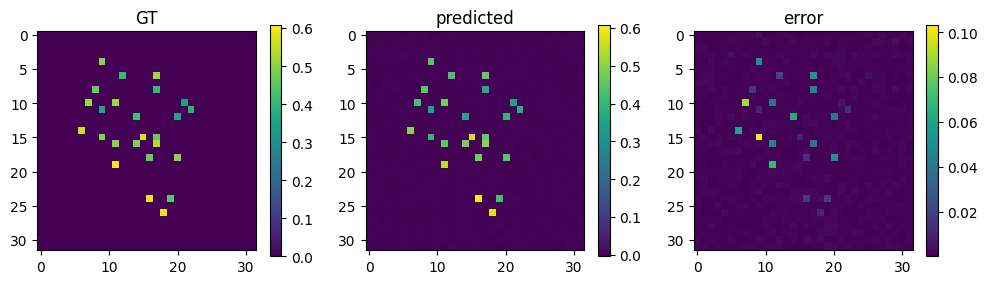

In [31]:
plt.figure(figsize = (12,3))
plt.subplot(1,3,1)
plt.imshow(label.reshape(32,32))
plt.title('GT')
plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(pre.reshape(32,32))
plt.title('predicted')
plt.colorbar()
plt.subplot(1,3,3)
plt.imshow(error.reshape(32,32))
plt.title('error')
plt.colorbar()
